In [11]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[4]").appName("main").getOrCreate()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

% matplotlib inline

# Reading a JSON as a dataframe

In [14]:
sdf = spark.read.json('../../data/reviews.json')

# Printing dataframe schema

In [15]:
sdf.printSchema()

root
 |-- asin: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)



# groupBy a column name and chain an aggregation function

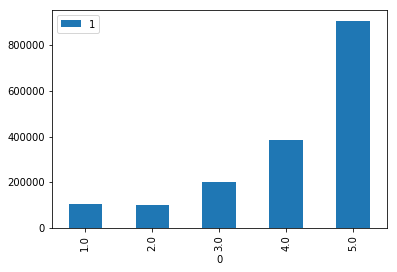

In [39]:
rating_distribution = sdf.groupBy('overall').count().collect()
rating_distribution = pd.DataFrame([(i['overall'], i['count']) for i in rating_distribution])
rating_distribution.sort_values(by = 0).plot(kind = 'bar', x = 0, y = 1)

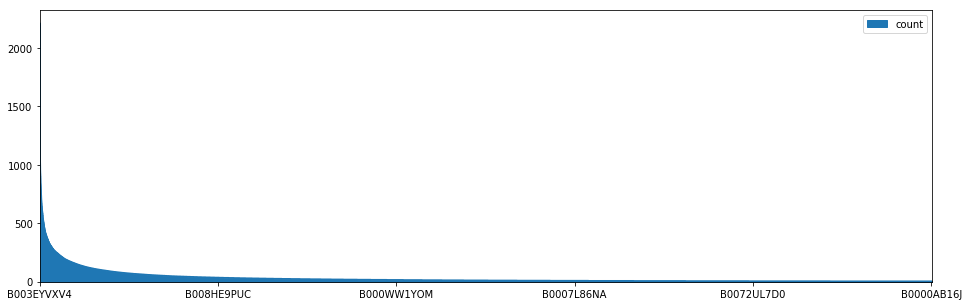

In [44]:
product_distribution = sdf.groupby('asin').count().collect()
product_distribution = pd.DataFrame([row['count'] for row in product_distribution],
                                    index = [row['asin'] for row in product_distribution], columns = ['count'])
product_distribution = product_distribution.sort_values(by = 'count', ascending = False)
product_distribution.plot(kind = 'area', figsize = (16,5))

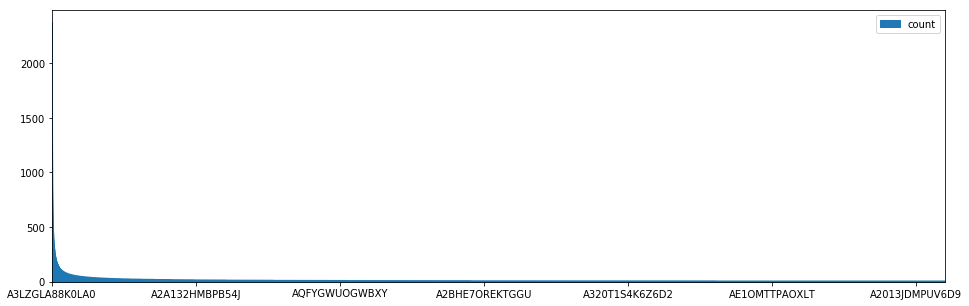

In [43]:
reviewer_distribution = df.groupby('reviewerID').count().collect()
reviewer_distribution = pd.DataFrame([row['count'] for row in reviewer_distribution],
                                    index = [row['reviewerID'] for row in reviewer_distribution], columns = ['count'])
reviewer_distribution = reviewer_distribution.sort_values(by = 'count', ascending = False)
reviewer_distribution.plot(kind = 'area', figsize = (16,5))

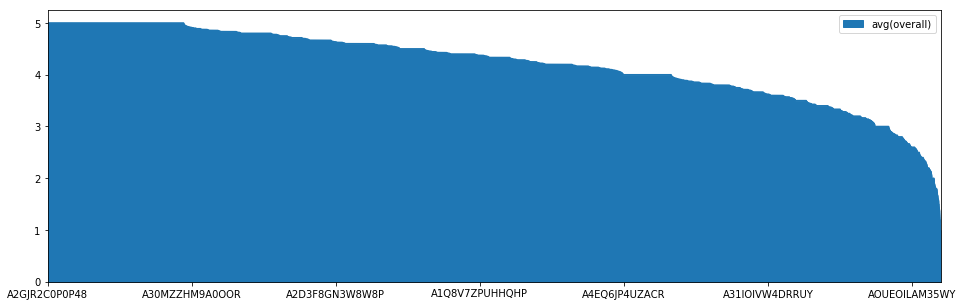

In [54]:
avg_rating_per_reviewer = sdf.groupBy('reviewerID')
avg_rating_per_reviewer = avg_rating_per_reviewer.mean().collect()
avg_rating_per_reviewer = pd.DataFrame([row['avg(overall)'] for row in avg_rating_per_reviewer],
                                      columns = ['avg(overall)'],
                                      index = [row['reviewerID'] for row in avg_rating_per_reviewer])
avg_rating_per_reviewer = avg_rating_per_reviewer.sort_values(by = 'avg(overall)', ascending = False)
avg_rating_per_reviewer.plot(kind = 'area', figsize = (16,5))

In [94]:
sdf.groupby('asin').avg().orderBy('avg(overall)').show(10)

+----------+------------------+-------------------+
|      asin|      avg(overall)|avg(unixReviewTime)|
+----------+------------------+-------------------+
|B004XZ99D2|               1.0|       1.38385152E9|
|B0010AEQ8Q|               1.0|        1.2491424E9|
|B000YVB81A|               1.0|        1.2742128E9|
|B00007G1YE|               1.0|       1.18910592E9|
|6303334385|               1.0|       1.05249024E9|
|B000E3LIJ0|               1.0|        1.1993328E9|
|B004LGGXHS|               1.0|       1.35727488E9|
|B00005J74W|               1.0|       1.05592896E9|
|B007C8RZPG|               1.0|        1.3612896E9|
|B0001ME5DU|1.0833333333333333|        1.1919672E9|
+----------+------------------+-------------------+
only showing top 10 rows



# Select a column and count distinct

In [60]:
sdf.select('asin').distinct().count()

50052

In [61]:
sdf.select('reviewerID').distinct().count()

123960

In [65]:
sdf.count()

1697533

# Filter for specific rows

In [74]:
sdf.filter(sdf['overall'] == 1).select('reviewText').take(5)

[Row(reviewText=u'The acting was good, the story was correct, but naked backsides was not necessary.  Also the Potiphers wife did not need to be so very seductive of a naked Joseph. Not a Christian movie.  I felt that even though it was probably portrayed truthfully, Christans do not need to see so explicit a scene.  This should be rated PG 13 at least.'),
 Row(reviewText=u"This is so lame! The songs are terrible! The villan is a ripoff of Mr. Burns from The Simpsons while the kids look like they're on loan from a Charlie Brown show. But the biggest lowpoint is the Politically Correct ranting! Too bad CBS insists on running this back-to-back with the 1969 classic."),
 Row(reviewText=u"This is with out a doubt is one of the worst Christmas movies I have ever seen!  My daughter liked it because it had a snowman in it, but that's the only reason.  The movie is filled with overdone, unrealistic, trite political issues of the 90's.  It was too complicated for a small child to follow and the

# Enable SQL queries

In [72]:
sdf.createOrReplaceTempView('reviews')
spark.sql('SELECT AVG(overall) FROM reviews').show()

+-----------------+
|     avg(overall)|
+-----------------+
|4.110648217148062|
+-----------------+



# Convert SDF to RDD

In [82]:
sdf.rdd.map(lambda x: x.overall).reduce(lambda x, y: x+y) / sdf.count()

4.110648217148062

In [ ]:
spark.stop()